In [ ]:
import sqlite3
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
from nltk.corpus import stopwords
import re
from mpl_toolkits.mplot3d import Axes3D
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
load_dotenv()


# Set MLflow experiment
mlflow.set_experiment("steam-reviews-clustering")
mlflow.autolog()


# ==========================================
# 1. DATA INGESTION (Load from SQLite)
# ==========================================
def load_data(db_path, table_name):
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Query: Select only the text column you need
    # Make sure to handle NULLs to avoid crashing the vectorizer
    query = f"SELECT review FROM {table_name}"
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"Loaded {len(df)} reviews.")
    return df

class TextPreprocessor:
    """
    A class to handle all text preprocessing steps
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        """Basic cleaning: lowercase, remove punctuation & numbers"""
        text = text.lower()
        # Remove numbers and punctuation in one regex pass
        text = re.sub(r'[^a-z\s]', '', text)
        # remove words with less than 2 words
        text = re.sub(r"\b\w{1}\b", " ", text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def clean_text_alternative(self, text):
        """Alternative: Keep more control over what to remove"""
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (keeps underscores)
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
        return text
    
    def remove_stopwords(self, text):
        """Remove common stopwords using regex word boundaries"""
        # Create pattern with word boundaries for exact matches
        pattern = r'\b(' + '|'.join(self.stop_words) + r')\b'
        text = re.sub(pattern, '', text)
        # Clean up extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def remove_stopwords_split(self, text):
        """Alternative: Traditional split approach (often faster for small stopword lists)"""
        words = text.split()
        return ' '.join([w for w in words if w not in self.stop_words])
    
    def stem_text(self, text):
        """Apply stemming with regex tokenization"""
        # Use regex to split on whitespace
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.stemmer.stem(w) for w in words])
    
    def lemmatize_text(self, text):
        """Apply lemmatization with regex tokenization"""
        # Use regex to extract words
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.lemmatizer.lemmatize(w) for w in words])
    
    def preprocess(self, text, remove_stops=True, use_lemma=True):
        """Complete preprocessing pipeline with optional advanced cleaning"""
        
        # Basic cleaning
        text = self.clean_text(text)
        
        # Stopword removal
        if remove_stops:
            text = self.remove_stopwords(text)
        
        # Stemming or Lemmatization
        if use_lemma:
            text = self.lemmatize_text(text)
        else:
            text = self.stem_text(text)
        
        return text

# ==========================================
# 2. PREPROCESSING & VECTORIZATION
# ==========================================
# We use TF-IDF to convert text to numbers.
# It lowers the weight of common words (the, a, is) and highlights unique keywords.
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English filler words
    max_features=1000,     # Keep only top important words to reduce noise
    ngram_range=(1, 3)     # Capture single words ("good") and pairs ("not good")
)

# ==========================================
# 3. CLUSTERING (K-Means)
# ==========================================
# Adjust 'n_clusters' based on how many groups you expect (e.g., Bugs, Gameplay, Story)
num_clusters = 5 
kmeans = KMeans(
    n_clusters=num_clusters, 
    random_state=42, 
    n_init=10
)

# ==========================================
# 4. EXECUTION
# ==========================================
# Create a dummy CSV for demonstration if you don't have the DB file ready immediately
df = load_data(r'E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db', 'reviews')
# -----------------------------
preprocessor = TextPreprocessor()
df['clean_review'] = df['review'].apply(preprocessor.preprocess)

# A. Transform Text to Vectors
tfidf_matrix = vectorizer.fit_transform(df['clean_review'])

# B. Fit K-Means
kmeans.fit(tfidf_matrix)

# C. Assign Labels back to DataFrame
df['cluster'] = kmeans.labels_

# ==========================================
# 5. ANALYSIS (Interpret the Clusters)
# ==========================================
print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()

for i in range(num_clusters):
    top_terms = [terms[ind] for ind in order_centroids[i, :10]] # Top 10 words
    print(f"Cluster {i}: {', '.join(top_terms)}")

# ==========================================
# 6. VISUALIZATION (PCA)
# ==========================================
# We squash the data into 2D so we can plot it
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(tfidf_matrix.toarray())
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(
    reduced_features[:, 0],  # X Axis
    reduced_features[:, 1],  # Y Axis
    reduced_features[:, 2],  # Z Axis
    c=df['cluster'],              
    cmap='viridis',               
    s=25,                         
    edgecolor='k',                
    alpha=0.5                  
)

plt.title('Review Clusters (2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend(title='Cluster ID')
plt.savefig('../results/clustering_embeddings.png')
plt.show()

# Colab

In [ ]:
import sqlite3
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
from nltk.corpus import stopwords
import re
from mpl_toolkits.mplot3d import Axes3D
from sentence_transformers import SentenceTransformer
from google.colab import userdata

from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')

os.environ['MLFLOW_TRACKING_URI'] = userdata.get('MLFLOW_TRACKING_URI')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('username')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('password')


# Set MLflow experiment
mlflow.set_experiment("steam-reviews-clustering")
mlflow.autolog()


# ==========================================
# 1. DATA INGESTION (Load from SQLite)
# ==========================================
def load_data(db_path, table_name):
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Query: Select only the text column you need
    # Make sure to handle NULLs to avoid crashing the vectorizer
    query = f"SELECT review, recommendationid FROM {table_name}"
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"Loaded {len(df)} reviews.")
    return df

class TextPreprocessor:
    """
    A class to handle all text preprocessing steps
    """
    
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
    
    def clean_text(self, text):
        """Basic cleaning: lowercase, remove punctuation & numbers"""
        text = text.lower()
        # Remove numbers and punctuation in one regex pass
        text = re.sub(r'[^a-z\s]', '', text)
        # remove words with less than 2 words
        text = re.sub(r"\b\w{1}\b", " ", text)
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def clean_text_alternative(self, text):
        """Alternative: Keep more control over what to remove"""
        text = text.lower()
        text = re.sub(r'\d+', '', text)  # Remove numbers
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation (keeps underscores)
        text = re.sub(r'\s+', ' ', text).strip()  # Normalize whitespace
        return text
    
    def remove_stopwords(self, text):
        """Remove common stopwords using regex word boundaries"""
        # Create pattern with word boundaries for exact matches
        pattern = r'\b(' + '|'.join(self.stop_words) + r')\b'
        text = re.sub(pattern, '', text)
        # Clean up extra spaces
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    def remove_stopwords_split(self, text):
        """Alternative: Traditional split approach (often faster for small stopword lists)"""
        words = text.split()
        return ' '.join([w for w in words if w not in self.stop_words])
    
    def stem_text(self, text):
        """Apply stemming with regex tokenization"""
        # Use regex to split on whitespace
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.stemmer.stem(w) for w in words])
    
    def lemmatize_text(self, text):
        """Apply lemmatization with regex tokenization"""
        # Use regex to extract words
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.lemmatizer.lemmatize(w) for w in words])
    
    def preprocess(self, text, remove_stops=True, use_lemma=True):
        """Complete preprocessing pipeline with optional advanced cleaning"""
        
        # Basic cleaning
        text = self.clean_text(text)
        
        # Stopword removal
        if remove_stops:
            text = self.remove_stopwords(text)
        
        # Stemming or Lemmatization
        if use_lemma:
            text = self.lemmatize_text(text)
        else:
            text = self.stem_text(text)
        
        return text

# ==========================================
# 2. PREPROCESSING & VECTORIZATION
# ==========================================
# We use TF-IDF to convert text to numbers.
# It lowers the weight of common words (the, a, is) and highlights unique keywords.
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English filler words
    max_features=1000,     # Keep only top important words to reduce noise
    ngram_range=(1, 3)     # Capture single words ("good") and pairs ("not good")
)

# ==========================================
# 2.a Embedding
# ==========================================
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# ==========================================
# 3. CLUSTERING (K-Means)
# ==========================================
# Adjust 'n_clusters' based on how many groups you expect (e.g., Bugs, Gameplay, Story)
num_clusters = 5 
kmeans = KMeans(
    n_clusters=num_clusters, 
    random_state=42, 
    n_init=10
)

# ==========================================
# 4. EXECUTION
# ==========================================
# Create a dummy CSV for demonstration if you don't have the DB file ready immediately
df = load_data(r'/content/gamesDB.db', 'reviews')
# -----------------------------
preprocessor = TextPreprocessor()
df['clean_review'] = df['review'].apply(preprocessor.preprocess)
embeddings = model.encode(df['clean_review'].tolist())

# A. Transform Text to Vectors
# tfidf_matrix = vectorizer.fit_transform(df['clean_review'])
# embeddings_matrix = embeddings.fit_transform(df['clean_review'])

# B. Fit K-Means
# kmeans.fit(tfidf_matrix)
kmeans.fit(embeddings)

# C. Assign Labels back to DataFrame
df['cluster'] = kmeans.labels_

# ==========================================
# 5. ANALYSIS (Interpret the Clusters)
# ==========================================
print("\n--- Top Terms per Cluster ---")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = embeddings.get_feature_names_out()

# for i in range(num_clusters):
#     top_terms = [terms[ind] for ind in order_centroids[i, :10]] # Top 10 words
#     print(f"Cluster {i}: {', '.join(top_terms)}")

# ==========================================
# 6. VISUALIZATION (PCA)
# ==========================================
# We squash the data into 2D so we can plot it
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(embeddings)
reduced_cluster_centers = pca.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(
    reduced_features[:, 0],  # X Axis
    reduced_features[:, 1],  # Y Axis
    reduced_features[:, 2],  # Z Axis
    c=df['cluster'],              # Colors based on cluster ID
    cmap='viridis',               # Color map
    s=25,                         # Dot size
    edgecolor='k',                # Black border around dots for visibility
    alpha=0.5                     # Transparency
)
# sns.scatterplot(
#     x=reduced_features[:, 0], 
#     y=reduced_features[:, 1], 
#     hue=df['cluster'], 
#     palette='viridis',
#     s=100
# )

plt.title('Review Clusters (2D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend(title='Cluster ID')
plt.savefig('/content/clustering_embeddings.png')
plt.show()

# Colab HDBSCAN

In [ ]:
import sqlite3
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
import os
from nltk.corpus import stopwords
import re
from mpl_toolkits.mplot3d import Axes3D
from sentence_transformers import SentenceTransformer
# from google.colab import userdata
from sklearn.metrics import silhouette_score
import hdbscan
from dotenv import load_dotenv

load_dotenv()

nltk.download('stopwords')
nltk.download('wordnet')

""" os.environ['MLFLOW_TRACKING_URI'] = userdata.get('MLFLOW_TRACKING_URI')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('username')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('password')
 """

# Set MLflow experiment
mlflow.set_experiment("steam-reviews-clustering")
mlflow.autolog()


# ==========================================
# 1. DATA INGESTION (Load from SQLite)
# ==========================================
def load_data(db_path, table_name):
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Query: Select only the text column you need
    # Make sure to handle NULLs to avoid crashing the vectorizer
    query = f"SELECT review FROM {table_name}"
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"Loaded {len(df)} reviews.")
    return df

def clean_text_minimal(text):
    """
    Minimal cleaning for Embeddings. 
    Removes HTML/URLs but KEEPS punctuation/emojis/stop-words.
    """
    if not isinstance(text, str): return ""
    text = re.sub(r'<.*?>', '', text)        # Remove HTML tags
    text = re.sub(r'\[.*?\]', '', text)      # Remove HTML tags with []
    text = re.sub(r'http\S+', '', text)      # Remove URLs
    text = re.sub(r'\s+', ' ', text).strip() # Fix excessive whitespace
    return text

# ==========================================
# 2. PREPROCESSING & VECTORIZATION
# ==========================================
# We use TF-IDF to convert text to numbers.
# It lowers the weight of common words (the, a, is) and highlights unique keywords.
vectorizer = TfidfVectorizer(
    stop_words='english',  # Remove common English filler words
    max_features=1000,     # Keep only top important words to reduce noise
    ngram_range=(1, 3)     # Capture single words ("good") and pairs ("not good")
)

# ==========================================
# 2.a Embedding
# ==========================================
model = SentenceTransformer(r'E:\models\all-MiniLM-L6-v2', device='cpu')

# ==========================================
# 3. CLUSTERING (K-Means)
# ==========================================
# Adjust 'n_clusters' based on how many groups you expect (e.g., Bugs, Gameplay, Story)
num_clusters = 5 
kmeans = KMeans(
    n_clusters=num_clusters, 
    random_state=42, 
    n_init=10
)

# ==========================================
# 3.A SILHOUETTE SCORE (Find Optimal K)
# ==========================================
print("\n--- Testing Cluster Counts (Silhouette Score) ---")

best_k = 2
best_score = -1
scores = []
k_range = range(2, 10 + 1)

# ==========================================
# 4. EXECUTION
# ==========================================
# Create a dummy CSV for demonstration if you don't have the DB file ready immediately
df = load_data(r'E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db', 'reviews')
df['clean_text'] = df['review'].apply(clean_text_minimal)
embeddings = model.encode(df['clean_text'].tolist(), normalize_embeddings=True)

# for k in k_range:
#     # 1. Run K-Means
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     labels = kmeans.fit_predict(embeddings)
    
#     # 2. Calculate Score (-1 is bad, +1 is perfect)
#     score = silhouette_score(embeddings, labels)
#     scores.append(score)
    
#     print(f"k={k}: Score = {score:.4f}")
    
#     # Track the winner
#     if score > best_score:
#         best_score = score
#         best_k = k

# print(f"\n✅ Optimal Number of Clusters: k={best_k} (Score: {best_score:.4f})")

# # Optional: Plot the score curve
# plt.figure(figsize=(8, 4))
# plt.plot(k_range, scores, marker='o', linestyle='--')
# plt.title('Silhouette Analysis')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Silhouette Score (Higher is Better)')
# plt.savefig('/content/shilhouette_score_chart.png')
# plt.grid(True)
# plt.show()

##################################################
############### Elbow Method  ####################
##################################################
# 3. Calculate Inertia for different k values
# inertia = []
# k_range = range(1, 7)  # Testing from 1 to 7 clusters

# for k in k_range:
#     kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
#     kmeans.fit(embeddings)
#     inertia.append(kmeans.inertia_)

# # 4. Plot the Elbow Curve
# plt.figure(figsize=(10, 6))
# plt.plot(k_range, inertia, marker='o', linestyle='-', color='b')
# plt.title('Elbow Method for Optimal k')
# plt.xlabel('Number of Clusters (k)')
# plt.ylabel('Inertia (Within-cluster Sum of Squares)')
# plt.xticks(k_range)
# plt.grid(True)
# plt.show()

# -----------------------------
# preprocessor = TextPreprocessor()
# df['clean_review'] = df['review'].apply(preprocessor.preprocess)

# A. Transform Text to Vectors
# tfidf_matrix = vectorizer.fit_transform(df['clean_review'])
# embeddings_matrix = embeddings.fit_transform(df['clean_review'])

# B. Fit K-Means
# kmeans.fit(tfidf_matrix)
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=15,
    metric="euclidean",  # cosine already handled by normalization
    cluster_selection_method="eom"
)

df['cluster'] = clusterer.fit_predict(embeddings)

# df['cluster'] = kmeans.fit_predict(embeddings)

# C. Assign Labels back to DataFrame
# df['cluster'] = kmeans.labels_

# ==========================================
# 5. ANALYSIS (Interpret the Clusters)
# ==========================================
# terms = embeddings.get_feature_names_out()

# for i in range(num_clusters):
#     top_terms = [terms[ind] for ind in order_centroids[i, :10]] # Top 10 words
#     print(f"Cluster {i}: {', '.join(top_terms)}")

# ==========================================
# 6. VISUALIZATION (PCA)
# ==========================================
# We squash the data into 2D so we can plot it
pca = PCA(n_components=3)
reduced_features = pca.fit_transform(embeddings)
# reduced_cluster_centers = pca.transform(clusterer.cluster_centers_)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')
scatter_3d = ax.scatter(
    reduced_features[:, 0],  # X Axis
    reduced_features[:, 1],  # Y Axis
    reduced_features[:, 2],  # Z Axis
    c=df['cluster'],              # Colors based on cluster ID
    cmap='viridis',               # Color map
    s=25,                         # Dot size
    edgecolor='k',                # Black border around dots for visibility
    alpha=0.5                     # Transparency
)
# sns.scatterplot(
#     x=reduced_features[:, 0], 
#     y=reduced_features[:, 1], 
#     hue=df['cluster'], 
#     palette='viridis',
#     s=100
# )

plt.title('Review Clusters (3D Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.ylabel('PCA Component 3')
plt.legend(title='Cluster ID')
plt.savefig('/content/clustering_embeddings.png')
plt.show()

# Colab BERTopic + HDBSCan

In [ ]:
"""
Production-Ready BERTopic Pipeline for Steam Reviews

Automatically discovers topics in game reviews with interpretable keywords
and handles large datasets efficiently.
"""

import sqlite3
import re
import time
from pathlib import Path
from typing import List, Tuple, Optional
import os
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import mlflow
from google.colab import userdata

os.environ['MLFLOW_TRACKING_URI'] = userdata.get('MLFLOW_TRACKING_URI')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('username')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('password')


# Set MLflow experiment
mlflow.set_experiment("steam-reviews-clustering")
# Set MLflow experiment
mlflow.set_experiment("steam-reviews-clustering")
with mlflow.start_run():
    # Log parameters
    mlflow.log_param("min_cluster_size", self.min_cluster_size)
    mlflow.log_param("embedding_model", "all-MiniLM-L6-v2")
    
    # ... existing fit code ...
    
    # Log metrics
    mlflow.log_metric("n_topics", n_topics)
    mlflow.log_metric("outlier_percentage", outlier_pct)



class SteamReviewTopicModeling:
    """BERTopic pipeline optimized for Steam game reviews"""
    
    def __init__(self, db_path: str, min_cluster_size: int = 50,
                 embedding_model: str = "all-MiniLM-L6-v2"):
        self.db_path = Path(db_path)
        self.min_cluster_size = min_cluster_size
        
        # Initialize models
        print(f"Loading embedding model: {embedding_model}")
        self.sentence_model = SentenceTransformer(embedding_model)
        
        self.hdbscan_model = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=10,
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True,
            core_dist_n_jobs=-1
        )
        
        # Custom vectorizer for better keyword extraction
        self.vectorizer_model = CountVectorizer(
            stop_words='english',
            ngram_range=(1, 2),
            min_df=5  # Ignore very rare words
        )
        
        self.topic_model = None
        self.embeddings = None
    
    @staticmethod
    def clean_steam_review(text: str) -> str:
        """Minimal cleaning preserving context for BERT"""
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # Remove Steam-specific metadata
        text = re.sub(r'Posted:.*', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\d+\.\d+\s*hrs on record', '', text)
        text = re.sub(r'Product received for free', '', text, flags=re.IGNORECASE)
        text = re.sub(r'Early Access Review', '', text, flags=re.IGNORECASE)
        
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def load_reviews(self, table_name: str = 'reviews',
                     text_column: str = 'review',
                     limit: Optional[int] = None,
                     return_dataframe: bool = True) -> pd.DataFrame:
        """Load and clean reviews from database
        
        Args:
            table_name: Database table name
            text_column: Column containing review text
            limit: Optional row limit for testing
            return_dataframe: If True, return DataFrame; if False, return list
            
        Returns:
            DataFrame with original data plus 'cleaned_text' column
        """
        
        print(f"\nLoading reviews from {self.db_path}...")
        
        # Load ALL columns to preserve metadata
        query = f"SELECT * FROM {table_name} WHERE {text_column} IS NOT NULL"
        if limit:
            query += f" LIMIT {limit}"
        
        try:
            with sqlite3.connect(self.db_path) as conn:
                df = pd.read_sql_query(query, conn)
        except Exception as e:
            print(f"✗ Database error: {e}")
            raise
        
        print(f"✓ Loaded {len(df)} raw reviews")
        
        # Add cleaned text as new column
        df['cleaned_text'] = df[text_column].apply(self.clean_steam_review)
        
        # Filter short/empty reviews
        min_words = 5
        df['is_valid'] = df['cleaned_text'].apply(
            lambda x: bool(x) and len(x.split()) >= min_words
        )
        
        # Keep only valid reviews
        df_valid = df[df['is_valid']].copy()
        df_valid = df_valid.drop(columns=['is_valid'])
        
        print(f"✓ After cleaning: {len(df_valid)} valid reviews (min {min_words} words)")
        print(f"  Filtered out: {len(df) - len(df_valid)} reviews")
        
        if return_dataframe:
            return df_valid
        else:
            return df_valid['cleaned_text'].tolist()
    
    def fit(self, reviews_df: pd.DataFrame, 
            text_column: str = 'cleaned_text',
            nr_topics: Optional[int] = None) -> Tuple[BERTopic, pd.DataFrame]:
        """Fit BERTopic model on reviews and return DataFrame with topics
        
        Args:
            reviews_df: DataFrame with reviews (from load_reviews)
            text_column: Column containing cleaned text
            nr_topics: Optional number to reduce topics to
            
        Returns:
            Tuple of (fitted_model, dataframe_with_topics)
        """
        
        print("\n" + "="*70)
        print("BERTOPIC MODELING")
        print("="*70)
        
        if len(reviews_df) == 0:
            raise ValueError("No reviews to process")
        
        reviews = reviews_df[text_column].tolist()
        
        # Pre-compute embeddings
        print(f"\nEncoding {len(reviews)} reviews...")
        start = time.time()
        
        self.embeddings = self.sentence_model.encode(
            reviews,
            show_progress_bar=True,
            batch_size=32,
            convert_to_numpy=True
        )
        
        print(f"✓ Encoding complete in {time.time()-start:.1f}s")
        print(f"  Embedding shape: {self.embeddings.shape}")
        
        # Initialize BERTopic
        self.topic_model = BERTopic(
            embedding_model=self.sentence_model,
            hdbscan_model=self.hdbscan_model,
            vectorizer_model=self.vectorizer_model,
            nr_topics=nr_topics,
            calculate_probabilities=False,
            verbose=True
        )
        
        # Fit model
        print("\nFitting topic model...")
        start = time.time()
        
        topics, probs = self.topic_model.fit_transform(reviews, self.embeddings)
        
        print(f"✓ Modeling complete in {time.time()-start:.1f}s")
        
        # Add topics back to DataFrame
        df_result = reviews_df.copy()
        df_result['topic'] = topics
        df_result['topic_name'] = df_result['topic'].apply(
            lambda x: self.topic_model.get_topic_info().loc[
                self.topic_model.get_topic_info()['Topic'] == x, 'Name'
            ].values[0] if x != -1 else 'Outlier'
        )
        
        # Analyze results
        self._print_summary(topics)
        
        return self.topic_model, df_result
    
    def _print_summary(self, topics: List[int]) -> None:
        """Print modeling summary statistics"""
        
        unique_topics = set(topics)
        n_topics = len(unique_topics) - (1 if -1 in unique_topics else 0)
        n_outliers = (np.array(topics) == -1).sum()
        outlier_pct = n_outliers / len(topics) * 100
        
        print("\n" + "="*70)
        print("TOPIC MODELING RESULTS")
        print("="*70)
        print(f"Total reviews:    {len(topics)}")
        print(f"Topics found:     {n_topics}")
        print(f"Outliers:         {n_outliers} ({outlier_pct:.1f}%)")
        
        if outlier_pct > 50:
            print("\n⚠️  WARNING: >50% outliers detected!")
            print("   Consider increasing min_cluster_size or providing more data")
        elif outlier_pct > 30:
            print("\n⚠️  High outlier rate - model may be too strict")
        else:
            print("\n✓ Outlier rate is reasonable")
        
        # Topic distribution
        topic_info = self.topic_model.get_topic_info()
        print(f"\nTop 5 largest topics:")
        print(topic_info.head(6)[['Topic', 'Count', 'Name']])  # Skip outlier topic
    
    def get_topic_keywords(self, topic_id: int, n_words: int = 10) -> List[Tuple[str, float]]:
        """Get top keywords for a specific topic"""
        return self.topic_model.get_topic(topic_id)[:n_words]
    
    def print_all_topics(self, n_words: int = 10, skip_outliers: bool = True) -> None:
        """Print all topics with their keywords"""
        
        print("\n" + "="*70)
        print("TOPIC KEYWORDS")
        print("="*70)
        
        topic_info = self.topic_model.get_topic_info()
        
        for _, row in topic_info.iterrows():
            topic_id = row['Topic']
            
            if skip_outliers and topic_id == -1:
                continue
            
            keywords = self.get_topic_keywords(topic_id, n_words)
            keyword_str = ', '.join([word for word, score in keywords])
            
            print(f"\nTopic {topic_id} (n={row['Count']}):")
            print(f"  {keyword_str}")
    
    def visualize(self, output_dir: str = "./outputs") -> None:
        """Generate and save visualizations"""
        
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        print("\n" + "="*70)
        print("GENERATING VISUALIZATIONS")
        print("="*70)
        
        visualizations = [
            ("topics", "Topic inter-distance map"),
            ("barchart", "Top topic keywords"),
            ("hierarchy", "Topic hierarchy"),
        ]
        
        for viz_type, description in visualizations:
            try:
                print(f"\nGenerating {description}...")
                
                if viz_type == "topics":
                    fig = self.topic_model.visualize_topics()
                elif viz_type == "barchart":
                    fig = self.topic_model.visualize_barchart(top_n_topics=10)
                elif viz_type == "hierarchy":
                    fig = self.topic_model.visualize_hierarchy()
                
                filepath = output_path / f"{viz_type}.html"
                fig.write_html(str(filepath))
                print(f"✓ Saved to {filepath}")
                
            except Exception as e:
                print(f"⚠️  Failed to generate {viz_type}: {e}")
    
    def save_model(self, path: str = "./bertopic_model") -> None:
        """Save trained model"""
        save_path = Path(path)
        save_path.mkdir(parents=True, exist_ok=True)
        
        print(f"\nSaving model to {save_path}...")
        self.topic_model.save(str(save_path))
        print("✓ Model saved")
    
    def load_model(self, path: str = "./bertopic_model") -> None:
        """Load pre-trained model"""
        print(f"\nLoading model from {path}...")
        self.topic_model = BERTopic.load(path)
        print("✓ Model loaded")
    
    def predict_topics(self, reviews_df: pd.DataFrame, 
                      text_column: str = 'cleaned_text') -> pd.DataFrame:
        """Predict topics for new reviews and return DataFrame with topics
        
        Args:
            reviews_df: DataFrame with reviews
            text_column: Column containing text to predict on
            
        Returns:
            DataFrame with added 'topic' and 'topic_name' columns
        """
        if self.topic_model is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        reviews = reviews_df[text_column].tolist()
        topics, probs = self.topic_model.transform(reviews)
        
        df_result = reviews_df.copy()
        df_result['topic'] = topics
        df_result['topic_name'] = df_result['topic'].apply(
            lambda x: self.topic_model.get_topic_info().loc[
                self.topic_model.get_topic_info()['Topic'] == x, 'Name'
            ].values[0] if x != -1 else 'Outlier'
        )
        
        return df_result


def main():
    """Example usage"""
    
    # Configuration
    DB_PATH = '/content/gamesDB.db'
    TABLE_NAME = 'reviews'
    TEXT_COLUMN = 'review'
    MIN_CLUSTER_SIZE = 50
    SAMPLE_SIZE = None
    
    # Initialize pipeline
    pipeline = SteamReviewTopicModeling(
        db_path=DB_PATH,
        min_cluster_size=MIN_CLUSTER_SIZE
    )
    
    # Load data as DataFrame (preserves all original columns)
    df = pipeline.load_reviews(
        table_name=TABLE_NAME,
        text_column=TEXT_COLUMN,
        limit=SAMPLE_SIZE,
        return_dataframe=True  # Returns DataFrame instead of list
    )
    
    print(f"\nDataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    if len(df) < 100:
        print("⚠️  Too few reviews for meaningful clustering")
        return
    
    # Fit model - returns DataFrame with topics
    topic_model, df_with_topics = pipeline.fit(df, text_column='cleaned_text')
    
    # Now you have all original columns PLUS topic information
    print("\nDataFrame with topics:")
    print(df_with_topics[['review', 'topic', 'topic_name']].head())
    
    # Analyze topics
    pipeline.print_all_topics(n_words=10)
    
    # Save DataFrame with topics
    output_path = Path("/content")
    output_path.mkdir(parents=True, exist_ok=True)
    
    df_with_topics.to_csv(output_path / "reviews_with_topics.csv", index=False)
    print(f"\n✓ Saved reviews with topics to {output_path / 'reviews_with_topics.csv'}")
    
    # Generate visualizations
    pipeline.visualize(output_dir=str(output_path))
    
    # Save model
    pipeline.save_model("/content/steam_topic_model")
    
    # Example: Filter reviews by topic
    print("\n" + "="*70)
    print("EXAMPLE QUERIES")
    print("="*70)
    
    # Get all reviews in topic 0
    topic_0_reviews = df_with_topics[df_with_topics['topic'] == 0]
    print(f"\nTopic 0 has {len(topic_0_reviews)} reviews")
    
    # Get topic distribution
    topic_dist = df_with_topics['topic'].value_counts().sort_index()
    print(f"\nTopic distribution:")
    print(topic_dist)
    
    # Get outliers
    outliers = df_with_topics[df_with_topics['topic'] == -1]
    print(f"\nOutliers: {len(outliers)} reviews")
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE")
    print("="*70)


if __name__ == "__main__":
    main()

# Colab BERTopic + HDBscan other parameters

In [ ]:
"""
Production-Ready BERTopic Pipeline for Steam Reviews

Automatically discovers topics in game reviews with interpretable keywords
and handles large datasets efficiently.
"""

import sqlite3
import re
import time
from pathlib import Path
from typing import List, Tuple, Optional
import os
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
import mlflow
from google.colab import userdata
from sklearn.decomposition import PCA


os.environ['MLFLOW_TRACKING_URI'] = userdata.get('MLFLOW_TRACKING_URI')
os.environ['MLFLOW_TRACKING_USERNAME'] = userdata.get('username')
os.environ['MLFLOW_TRACKING_PASSWORD'] = userdata.get('password')

mlflow.set_experiment('steam-reviews-clustering')
mlflow.autolog()

# # Set MLflow experiment
# mlflow.set_experiment("steam-reviews-clustering")
# # Set MLflow experiment
# mlflow.set_experiment("steam-reviews-clustering")
# with mlflow.start_run():
#     # Log parameters
#     mlflow.log_param("min_cluster_size", self.min_cluster_size)
#     mlflow.log_param("embedding_model", "all-MiniLM-L6-v2")
    
#     # ... existing fit code ...
    
#     # Log metrics
#     mlflow.log_metric("n_topics", n_topics)
#     mlflow.log_metric("outlier_percentage", outlier_pct)



class SteamReviewTopicModeling:
    """BERTopic pipeline optimized for Steam game reviews"""
    
    def __init__(self, db_path: str, min_cluster_size: int = 100,
                 embedding_model: str = "all-MiniLM-L6-v2", min_samples: int = 10):
        self.db_path = Path(db_path)
        self.min_cluster_size = min_cluster_size
        
        # Initialize models
        print(f"Loading embedding model: {embedding_model}")
        self.sentence_model = SentenceTransformer(embedding_model)
        
        self.hdbscan_model = HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='euclidean',
            cluster_selection_method='eom',
            prediction_data=True,
            core_dist_n_jobs=-1
        )
        
        # Custom vectorizer for better keyword extraction
        self.vectorizer_model = CountVectorizer(
            max_features=1000,
            stop_words='english',
            ngram_range=(1, 3),
            min_df=10,
            max_df=0.7  # Ignore very rare words
        )
        
        self.topic_model = None
        self.embeddings = None
    
    @staticmethod
    def clean_steam_review(text: str) -> str:
        """Minimal cleaning preserving context for BERT"""
        if not isinstance(text, str) or not text.strip():
            return ""
        
        # Remove Steam-specific metadata
        text = re.sub(r'Posted:.*', '', text, flags=re.IGNORECASE)
        text = re.sub(r'\d+\.\d+\s*hrs on record', '', text)
        text = re.sub(r'Product received for free', '', text, flags=re.IGNORECASE)
        text = re.sub(r'Early Access Review', '', text, flags=re.IGNORECASE)
        
        # Remove excessive whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def load_reviews(self, table_name: str = 'reviews',
                     text_column: str = 'review',
                     limit: Optional[int] = None,
                     return_dataframe: bool = True) -> pd.DataFrame:
        """Load and clean reviews from database
        
        Args:
            table_name: Database table name
            text_column: Column containing review text
            limit: Optional row limit for testing
            return_dataframe: If True, return DataFrame; if False, return list
            
        Returns:
            DataFrame with original data plus 'cleaned_text' column
        """
        
        print(f"\nLoading reviews from {self.db_path}...")
        
        # Load ALL columns to preserve metadata
        query = f"SELECT * FROM {table_name} WHERE {text_column} IS NOT NULL"
        if limit:
            query += f" LIMIT {limit}"
        
        try:
            with sqlite3.connect(self.db_path) as conn:
                df = pd.read_sql_query(query, conn)
        except Exception as e:
            print(f"✗ Database error: {e}")
            raise
        
        print(f"✓ Loaded {len(df)} raw reviews")
        
        # Add cleaned text as new column
        df['cleaned_text'] = df[text_column].apply(self.clean_steam_review)
        
        # Filter short/empty reviews
        min_words = 5
        df['is_valid'] = df['cleaned_text'].apply(
            lambda x: bool(x) and len(x.split()) >= min_words
        )
        
        # Keep only valid reviews
        df_valid = df[df['is_valid']].copy()
        df_valid = df_valid.drop(columns=['is_valid'])
        
        print(f"✓ After cleaning: {len(df_valid)} valid reviews (min {min_words} words)")
        print(f"  Filtered out: {len(df) - len(df_valid)} reviews")
        
        if return_dataframe:
            return df_valid
        else:
            return df_valid['cleaned_text'].tolist()
    
    def fit(self, reviews_df: pd.DataFrame, 
            text_column: str = 'cleaned_text',
            nr_topics: Optional[int] = None) -> Tuple[BERTopic, pd.DataFrame]:
        """Fit BERTopic model on reviews and return DataFrame with topics
        
        Args:
            reviews_df: DataFrame with reviews (from load_reviews)
            text_column: Column containing cleaned text
            nr_topics: Optional number to reduce topics to
            
        Returns:
            Tuple of (fitted_model, dataframe_with_topics)
        """
        
        print("\n" + "="*70)
        print("BERTOPIC MODELING")
        print("="*70)
        
        if len(reviews_df) == 0:
            raise ValueError("No reviews to process")
        
        reviews = reviews_df[text_column].tolist()
        
        # Pre-compute embeddings
        print(f"\nEncoding {len(reviews)} reviews...")
        start = time.time()
        
        self.embeddings = self.sentence_model.encode(
            reviews,
            show_progress_bar=True,
            batch_size=32,
            convert_to_numpy=True
        )
        
        print(f"✓ Encoding complete in {time.time()-start:.1f}s")
        print(f"  Embedding shape: {self.embeddings.shape}")
        
        # Initialize BERTopic
        self.topic_model = BERTopic(
            embedding_model=self.sentence_model,
            hdbscan_model=self.hdbscan_model,
            vectorizer_model=self.vectorizer_model,
            nr_topics=nr_topics,
            calculate_probabilities=False,
            verbose=True
        )
        
        # Fit model
        print("\nFitting topic model...")
        start = time.time()

        # Reduce dimensionality
        embeddings_pca = PCA(
                        n_components=50,
                        whiten=False
                        ).fit_transform(self.embeddings)
        
        topics, probs = self.topic_model.fit_transform(reviews, embeddings_pca)
        
        print(f"✓ Modeling complete in {time.time()-start:.1f}s")
        
        # Add topics back to DataFrame
        df_result = reviews_df.copy()
        df_result['topic'] = topics
        df_result['topic_name'] = df_result['topic'].apply(
            lambda x: self.topic_model.get_topic_info().loc[
                self.topic_model.get_topic_info()['Topic'] == x, 'Name'
            ].values[0] if x != -1 else 'Outlier'
        )
        
        # Analyze results
        self._print_summary(topics)
        
        return self.topic_model, df_result
    
    def _print_summary(self, topics: List[int]) -> None:
        """Print modeling summary statistics"""
        
        unique_topics = set(topics)
        n_topics = len(unique_topics) - (1 if -1 in unique_topics else 0)
        n_outliers = (np.array(topics) == -1).sum()
        outlier_pct = n_outliers / len(topics) * 100
        
        print("\n" + "="*70)
        print("TOPIC MODELING RESULTS")
        print("="*70)
        print(f"Total reviews:    {len(topics)}")
        print(f"Topics found:     {n_topics}")
        print(f"Outliers:         {n_outliers} ({outlier_pct:.1f}%)")
        
        if outlier_pct > 50:
            print("\n⚠️  WARNING: >50% outliers detected!")
            print("   Consider increasing min_cluster_size or providing more data")
        elif outlier_pct > 30:
            print("\n⚠️  High outlier rate - model may be too strict")
        else:
            print("\n✓ Outlier rate is reasonable")
        
        # Topic distribution
        topic_info = self.topic_model.get_topic_info()
        print(f"\nTop 5 largest topics:")
        print(topic_info.head(6)[['Topic', 'Count', 'Name']])  # Skip outlier topic
    
    def get_topic_keywords(self, topic_id: int, n_words: int = 10) -> List[Tuple[str, float]]:
        """Get top keywords for a specific topic"""
        return self.topic_model.get_topic(topic_id)[:n_words]
    
    def print_all_topics(self, n_words: int = 10, skip_outliers: bool = True) -> None:
        """Print all topics with their keywords"""
        
        print("\n" + "="*70)
        print("TOPIC KEYWORDS")
        print("="*70)
        
        topic_info = self.topic_model.get_topic_info()
        
        for _, row in topic_info.iterrows():
            topic_id = row['Topic']
            
            if skip_outliers and topic_id == -1:
                continue
            
            keywords = self.get_topic_keywords(topic_id, n_words)
            keyword_str = ', '.join([word for word, score in keywords])
            
            print(f"\nTopic {topic_id} (n={row['Count']}):")
            print(f"  {keyword_str}")
    
    def visualize(self, output_dir: str = "./outputs") -> None:
        """Generate and save visualizations"""
        
        output_path = Path(output_dir)
        output_path.mkdir(parents=True, exist_ok=True)
        
        print("\n" + "="*70)
        print("GENERATING VISUALIZATIONS")
        print("="*70)
        
        visualizations = [
            ("topics", "Topic inter-distance map"),
            ("barchart", "Top topic keywords"),
            ("hierarchy", "Topic hierarchy"),
        ]
        
        for viz_type, description in visualizations:
            try:
                print(f"\nGenerating {description}...")
                
                if viz_type == "topics":
                    fig = self.topic_model.visualize_topics()
                elif viz_type == "barchart":
                    fig = self.topic_model.visualize_barchart(top_n_topics=10)
                elif viz_type == "hierarchy":
                    fig = self.topic_model.visualize_hierarchy()
                
                filepath = output_path / f"{viz_type}.html"
                fig.write_html(str(filepath))
                print(f"✓ Saved to {filepath}")
                
            except Exception as e:
                print(f"⚠️  Failed to generate {viz_type}: {e}")
    
    def save_model(self, path: str = "./bertopic_model") -> None:
        """Save trained model"""
        save_path = Path(path)
        save_path.mkdir(parents=True, exist_ok=True)
        
        print(f"\nSaving model to {save_path}...")
        
        # Save with explicit serialization parameter
        self.topic_model.save(
            save_path,
            serialization="safetensors",  # Explicit serialization
            save_ctfidf=True,
            save_embedding_model=self.sentence_model
        )
    
    def load_model(self, path: str = "./bertopic_model") -> None:
        """Load pre-trained model"""
        print(f"\nLoading model from {path}...")
        self.topic_model = BERTopic.load(path)
        print("✓ Model loaded")
    
    def predict_topics(self, reviews_df: pd.DataFrame, 
                      text_column: str = 'cleaned_text') -> pd.DataFrame:
        """Predict topics for new reviews and return DataFrame with topics
        
        Args:
            reviews_df: DataFrame with reviews
            text_column: Column containing text to predict on
            
        Returns:
            DataFrame with added 'topic' and 'topic_name' columns
        """
        if self.topic_model is None:
            raise ValueError("Model not fitted. Call fit() first.")
        
        reviews = reviews_df[text_column].tolist()
        topics, probs = self.topic_model.transform(reviews)
        
        df_result = reviews_df.copy()
        df_result['topic'] = topics
        df_result['topic_name'] = df_result['topic'].apply(
            lambda x: self.topic_model.get_topic_info().loc[
                self.topic_model.get_topic_info()['Topic'] == x, 'Name'
            ].values[0] if x != -1 else 'Outlier'
        )
        
        return df_result


def main():
    """Example usage"""
    
    # Configuration
    DB_PATH = '/content/gamesDB.db'
    TABLE_NAME = 'reviews'
    TEXT_COLUMN = 'review'
    MIN_CLUSTER_SIZE = 400
    MIN_SAMPLES = 35
    SAMPLE_SIZE = None
    NR_TOPICS = 12
    
    # Initialize pipeline
    pipeline = SteamReviewTopicModeling(
        db_path=DB_PATH,
        min_cluster_size=MIN_CLUSTER_SIZE,
        min_samples=MIN_SAMPLES
    )
    
    # Load data as DataFrame (preserves all original columns)
    df = pipeline.load_reviews(
        table_name=TABLE_NAME,
        text_column=TEXT_COLUMN,
        limit=SAMPLE_SIZE,
        return_dataframe=True  # Returns DataFrame instead of list
    )
    
    print(f"\nDataFrame shape: {df.shape}")
    print(f"Columns: {df.columns.tolist()}")
    
    if len(df) < 100:
        print("⚠️  Too few reviews for meaningful clustering")
        return
    
    # Fit model - returns DataFrame with topics
    topic_model, df_with_topics = pipeline.fit(df, text_column='cleaned_text', nr_topics=NR_TOPICS)
    
    # Now you have all original columns PLUS topic information
    print("\nDataFrame with topics:")
    print(df_with_topics[['review', 'topic', 'topic_name']].head())
    
    # Analyze topics
    pipeline.print_all_topics(n_words=10)
    
    # Save DataFrame with topics
    output_path = Path("/content")
    output_path.mkdir(parents=True, exist_ok=True)
    
    df_with_topics.to_csv(output_path / "reviews_with_topics.csv", index=False)
    print(f"\n✓ Saved reviews with topics to {output_path / 'reviews_with_topics.csv'}")
    
    # Generate visualizations
    pipeline.visualize(output_dir=str(output_path))
    
    # Save model
    pipeline.save_model(path="/content")
    
    # Example: Filter reviews by topic
    print("\n" + "="*70)
    print("EXAMPLE QUERIES")
    print("="*70)
    
    # Get all reviews in topic 0
    topic_0_reviews = df_with_topics[df_with_topics['topic'] == 0]
    print(f"\nTopic 0 has {len(topic_0_reviews)} reviews")
    
    # Get topic distribution
    topic_dist = df_with_topics['topic'].value_counts().sort_index()
    print(f"\nTopic distribution:")
    print(topic_dist)
    
    # Get outliers
    outliers = df_with_topics[df_with_topics['topic'] == -1]
    print(f"\nOutliers: {len(outliers)} reviews")
    
    print("\n" + "="*70)
    print("PIPELINE COMPLETE")
    print("="*70)


if __name__ == "__main__":
    with mlflow.start_run():
        main()

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
import sqlite3
import mlflow
import pandas as pd
from nltk.corpus import stopwords
import re
import os
import pickle
import joblib
# from google.colab import userdata
from dotenv import load_dotenv

load_dotenv()

def load_data(db_path, table_name):
    # Connect to database
    conn = sqlite3.connect(db_path)
    
    # Query: Select only the text column you need
    # Make sure to handle NULLs to avoid crashing the vectorizer
    query = f"SELECT review, recommendationid FROM {table_name}"
    
    df = pd.read_sql_query(query, conn)
    conn.close()
    print(f"Loaded {len(df)} reviews.")
    return df

def clean_steam_review(text: str) -> str:
    """Minimal cleaning preserving context for BERT"""

    if not isinstance(text, str) or not text.strip():
        return ""
    
    STEAM_PATTERNS = [
        r"\b\d{1,4}\s?hrs?\b",
        r"\b\d{1,4}\s?hours?\b",
        r"\bplay(ed|ing)?\b",
        r"\bupdate\b",
        r"\bpatch\b",
        r"\bdevs?\b",
        r"\bdev(eloper)?s?\b",
        r"\bearly access\b",
        r"\brefund(ed|ing)?\b",
        r"\brecommend(ed|ing)?\b",
        r"\bnot recommend(ed|ing)?\b",
        r"\bworth it\b",
        r"\bprice\b",
        r"\bperformance\b",
        r"\bfps\b",
        r"\blag\b",
        r"\bcrash(es|ed)?\b",
    ]

    def lemmatize_text(self, text):
        """Apply lemmatization with regex tokenization"""
        # Use regex to extract words
        words = re.findall(r'\b\w+\b', text)
        return ' '.join([self.lemmatizer.lemmatize(w) for w in words])

    for p in STEAM_PATTERNS:
        text = re.sub(p, " ", text, flags=re.I)
    
    text = lemmatize_text(text)
    
    # Remove Steam-specific metadata
    text = re.sub(r'Posted:.*', '', text, flags=re.IGNORECASE)
    text = re.sub(r'\d+\.\d+\s*hrs on record', '', text)
    text = re.sub(r'Product received for free', '', text, flags=re.IGNORECASE)
    text = re.sub(r'Early Access Review', '', text, flags=re.IGNORECASE)
    text = re.sub(r'http\S+', '', text)
    
    # Remove excessive whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    text = text.lower()

    return text

def get_top_words(lda, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(lda.components_):
        top_features = topic.argsort()[:-n_top_words - 1:-1]
        topics[topic_idx] = [feature_names[i] for i in top_features]
    return topics

def main():
    DB_PATH = r'E:\SynologyDrive\ironhack\week_14\day_2\nlp-business-case-automated-customers-reviews\data\raw\gamesDB.db'
    TABLE_NAME = 'reviews'

    df = load_data(DB_PATH, TABLE_NAME)
    # Vectorize
    custom_stopwords = [
        'game', 'play', 'horror', 'scary', 'recommend',
        'worth', 'fun', 'good', 'bad', 'great', 'get', 'like',
        'time'
    ]

    vectorizer = CountVectorizer(
        max_features=1500,
        stop_words=list(set(stopwords.words('english') + custom_stopwords)),
        ngram_range=(2, 3),
        min_df=15,
        max_df=0.6  # Ignore words in >70% of reviews
    )

    df = df[(df.len >= 20)]

    df['clean_text'] = df['review'].apply(clean_steam_review)

    X = vectorizer.fit_transform(df['clean_text'])

    # LDA
    lda = LatentDirichletAllocation(
        n_components=12,  # Fewer topics
        random_state=42,
        n_jobs=1
    )
    topics = lda.fit_transform(X)
    doc_topics = topics.argmax(axis=1)
    doc_confidence = topics.max(axis=1)

    feature_names = vectorizer.get_feature_names_out()
    topic_words = get_top_words(lda, feature_names)

    for k, words in topic_words.items():
        print(f"Topic {k}: {', '.join(words)}")
    perplexity = lda.perplexity(X)
    print("Perplexity:", perplexity)

    df["topic"] = topics.argmax(axis=1)
    df.to_csv('lda_topics.csv', index=False, sep=';')

    joblib.dump(
    {
        "vectorizer": vectorizer,
        "lda": lda
    },
    "lda_pipeline.joblib"
)

if __name__ == '__main__':
    mlflow.set_experiment('steam-reviews-clustering')
    mlflow.autolog()
    with mlflow.start_run():
        main()

In [7]:
df = pd.read_csv('lda_topics.csv', sep=';')

<Axes: xlabel='topic'>

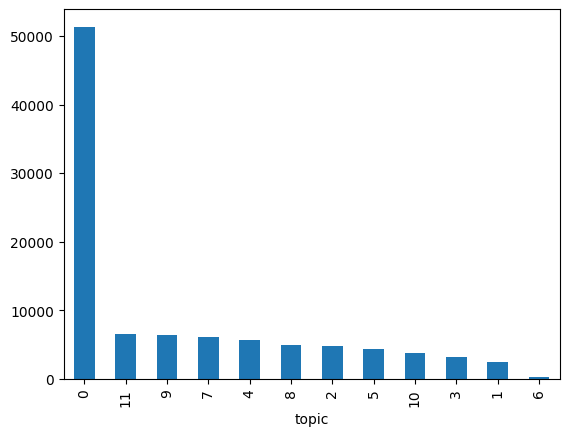

In [10]:
df['topic'].value_counts().plot(kind='bar')

In [14]:
df4 = df[df['topic'] == 4]

In [15]:
df4

,review,recommendationid,clean_text,topic
9,"Survival: Lost Way, developed by SimplePlan an...",208225932,"Survival: Lost Way, developed by SimplePlan an...",4
37,"Batim isn't too long or short, it is a perfect...",209511528,"Batim isn't too long or short, it is a perfect...",4
115,A game I bought all the way back in 2019 and o...,208296570,A game I bought all the way back in 2019 and o...,4
148,silly ink men...and women....(projectionist is...,206305662,silly ink men...and women....(projectionist is...,4
212,I have alot to say about this chapter(s) some ...,35396557,I have alot to say about this chapter(s) some ...,4
...,...,...,...,...
100076,1/10 – Just Survive: A Survivalist Manual for ...,200150203,1/10 – Just Survive: A Survivalist Manual for ...,4
100121,Once upon a time...\n- Its name was H1Z1\n- Th...,26746424,Once upon a time... - Its name was H1Z1 - The ...,4
100166,I put 800 hours in the first 4 months after bu...,24607300,I put 800 hours in the first 4 months after bu...,4
100201,"at this point in time i can't recommend it, as...",19269522,"at this point in time i can't recommend it, as...",4
